In [1]:
!pip install torchsummary
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=d258b6c04a5b14690b5ee7eaed1b7619634ca36d7745dbd3a2bbcd23138255fc
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


Computer Vision - Multiclass Classification

Dataset: Dog Breed Identification, from: https://www.kaggle.com/c/dog-breed-identification/overview

Method: Comparing Models
- ResNet50
- EfficientNet
- VGG16
- InceptionV3

Metric: Cross Entropy Loss, Accuracy

Note: Runtime: ~12 to 15 minutes for all models to train 1 epoch (use kaggle cuda gpu)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.optim import lr_scheduler
from torchsummary import summary
from efficientnet_pytorch import EfficientNet

import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
from PIL import ImageFile
from IPython.display import display

ImageFile.LOAD_TRUNCATED_IMAGES = True

import glob
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

Read the dataset

The dataset provided has a training set and a test set of images of dogs but we only use the training set because the test set has hidden labels. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. The goal is to create a classifier capable of determining a dog's breed from a photo.

In [4]:
PATH = '../input/dog-breed-identification/'
labels = pd.read_csv(PATH + 'labels.csv')
labelnames = pd.read_csv(PATH + 'sample_submission.csv').keys()[1:]
print("Train folder has ", len(os.listdir(PATH+'train')),'images which matches with label\'s', len(labels),'images')

Train folder has  10222 images which matches with label's 10222 images


Basic Visualization of Dog Breed distribution

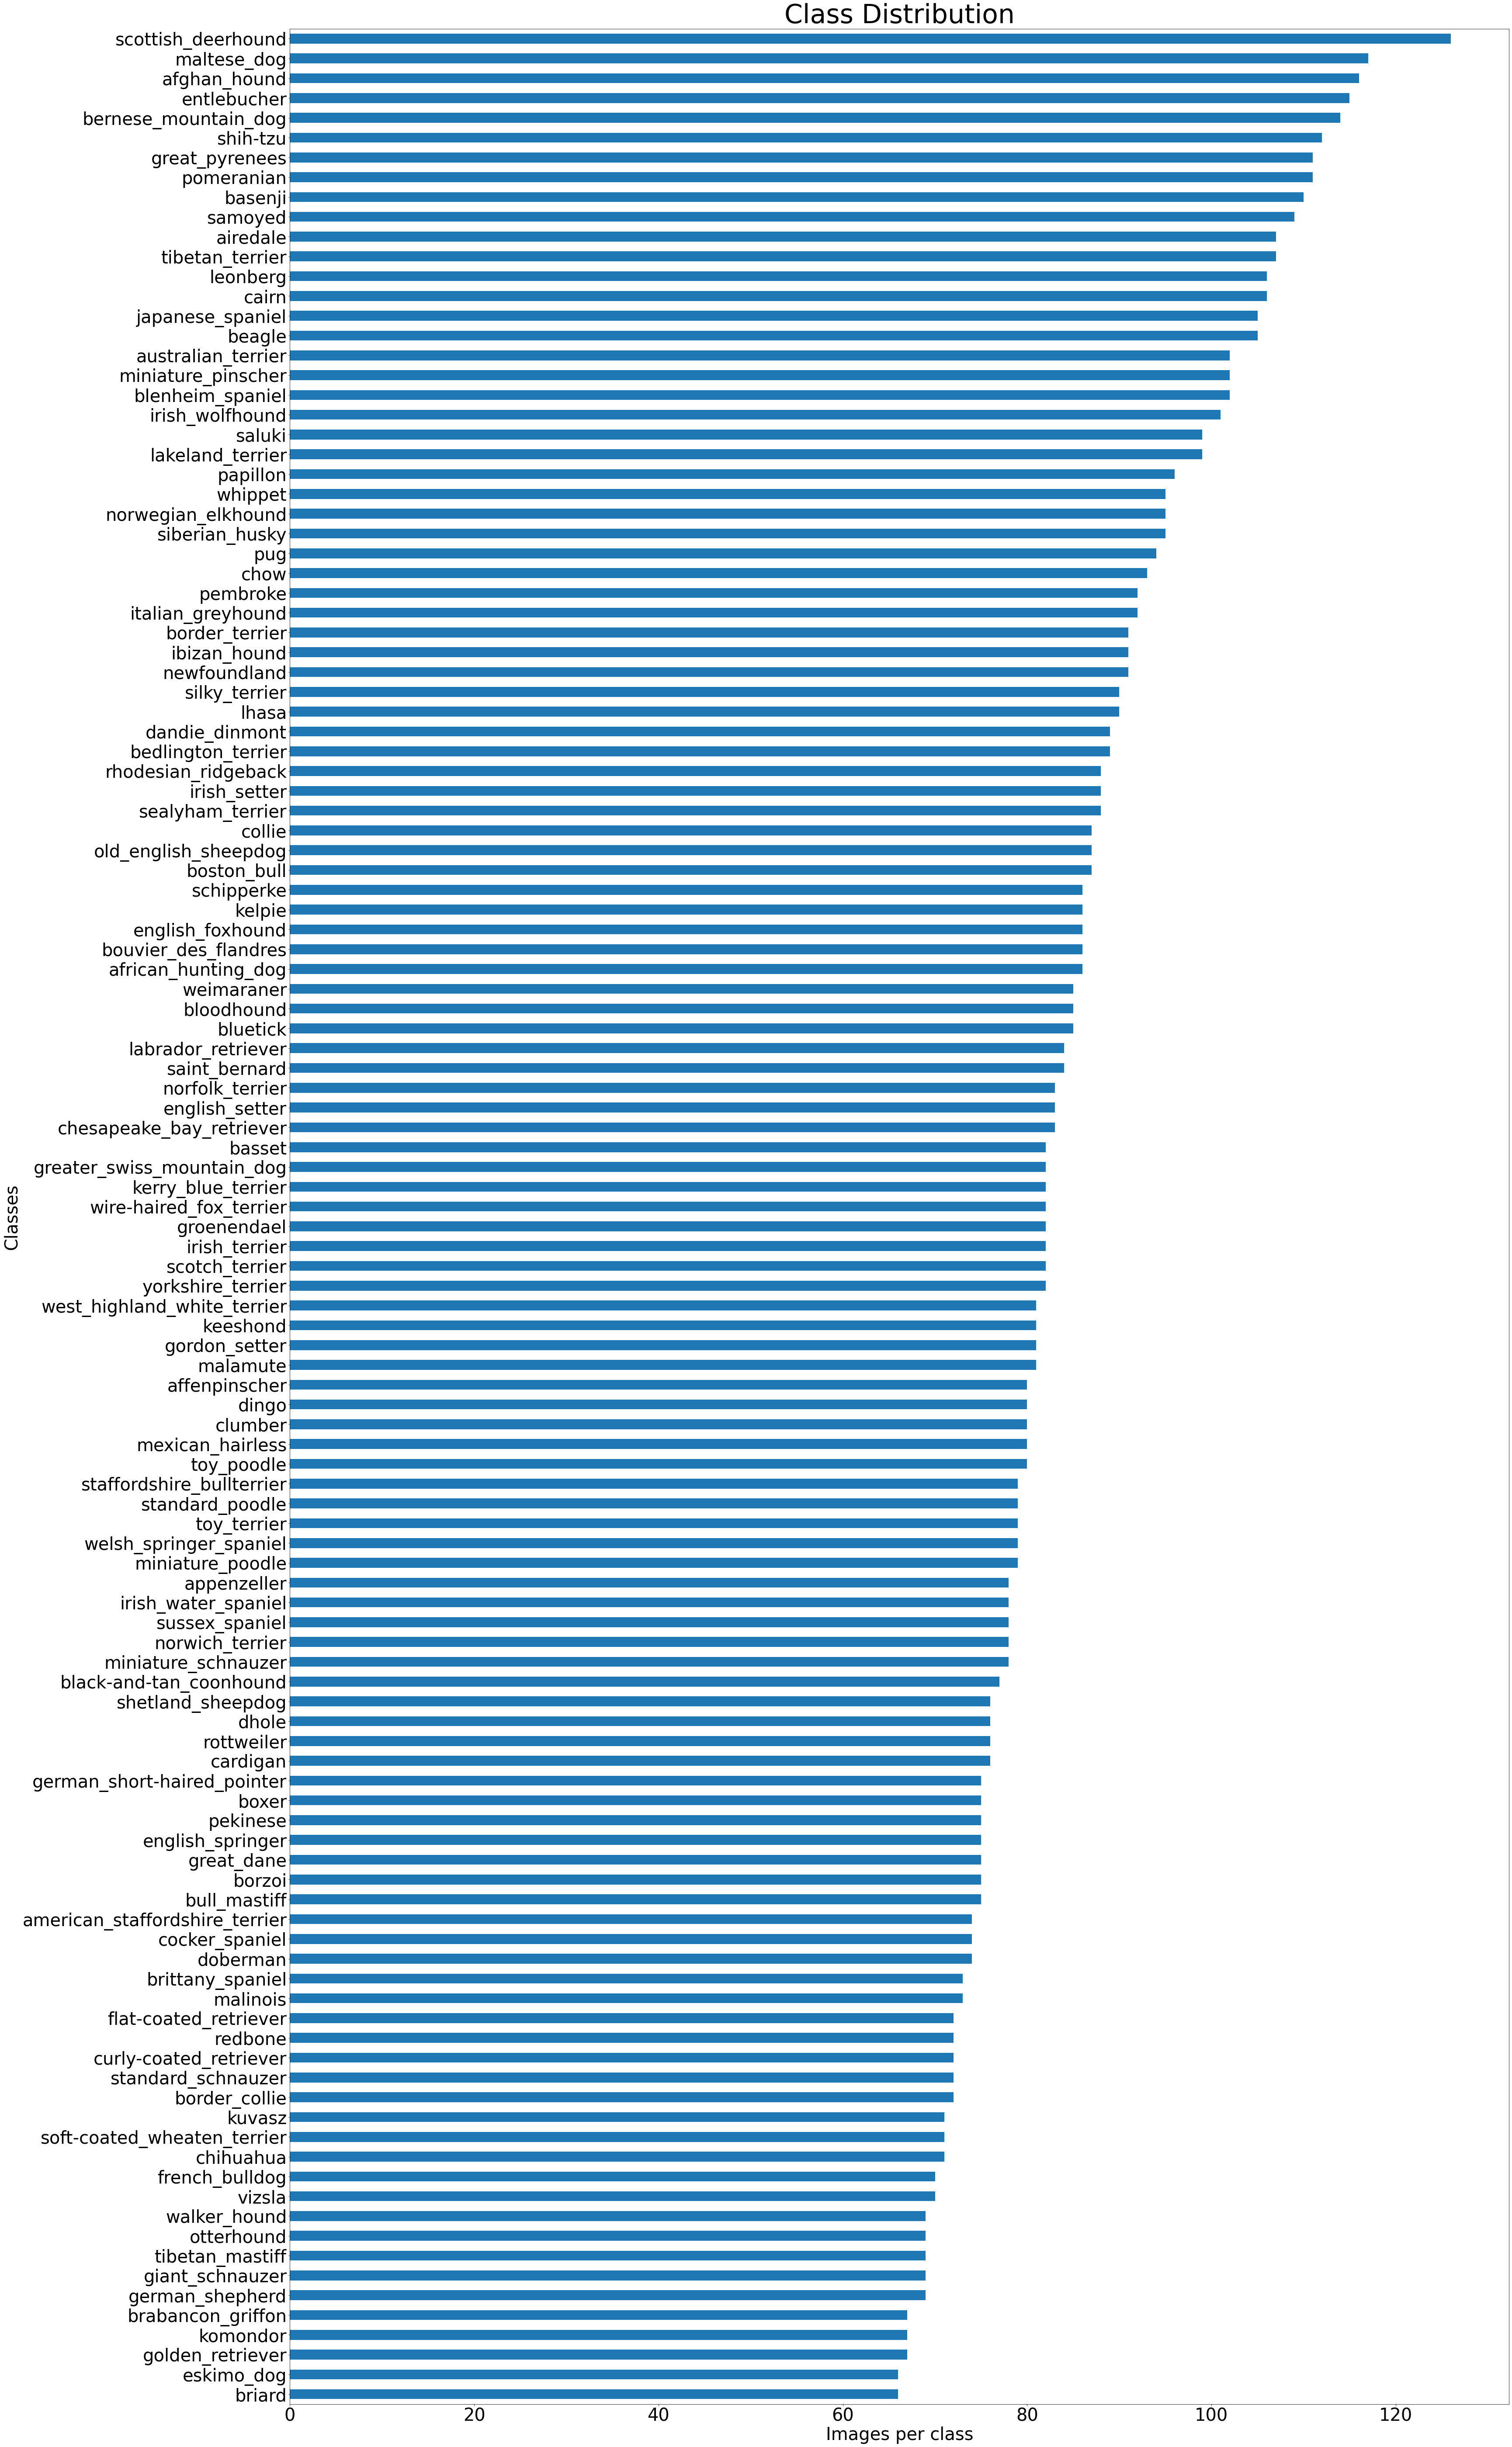

In [5]:
img_file = PATH+'train'

df=labels.assign(img_path=lambda x: img_file + x['id'] +'.jpg')

ax=pd.value_counts(df['breed'],ascending=True).plot(kind='barh',fontsize="40",title="Class Distribution",figsize=(50,100))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.title.set_size(60)
plt.show()

Create a mapping between breed to code and code to breed to easily connect the data in two directions

One hot encodding applied to the breed type

Split the dataset into

Train: 7666 datas (75%)

Validation: 1534 datas (15%)

Test: 1022 datas (10%)

In [6]:
codes = range(len(labelnames))
breed_to_code = dict(zip(labelnames, codes))
code_to_breed = dict(zip(codes, labelnames))
labels['target'] =  [breed_to_code[x] for x in labels.breed]
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.75)
temp = labels_pivot[~labels_pivot['id'].isin(train['id'])]
valid = temp.sample(frac=0.6)
test = temp[~temp['id'].isin(valid['id'])]
print("Train shape: ", train.shape)
print("Validation shape: ", valid.shape)
print("Test shape:", test.shape)
print("Data shape overview (Train):")
print(train)

Train shape:  (7666, 121)
Validation shape:  (1534, 121)
Test shape: (1022, 121)
Data shape overview (Train):
breed                                id  affenpinscher  afghan_hound  \
2882   475171ec5847e4df41847e295b8cfca2            0.0           0.0   
4514   70c412a3ce894c617cbe707f24adbb82            0.0           0.0   
7717   c13427fc3db9194dac02b1721bd10fe4            0.0           0.0   
33     00e9ed3fab1d2032603d1a90e557976f            0.0           0.0   
4924   7ba8102be491368fa69e832b3f1cec42            0.0           0.0   
...                                 ...            ...           ...   
5879   945adc048fc9ca656180736fd60cf8d1            0.0           0.0   
8612   d84cd331a97cb5ee7d08974724f7055f            0.0           0.0   
4542   718efe7ac68c55e355c44049d40876c5            0.0           0.0   
9533   ef029489fc2941792a5460afd7345fcc            0.0           0.0   
7193   b43ec84e89e07bd43395777a5dcc0bc1            0.0           0.0   

breed  african_hunting_do

In [7]:
labels.head(5)

,id,breed,target
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,49


The image is resized to 256x256 and then cropped the image into 224x224 randomly to avoid squashed images and normalized it using Imagenet's mean and standard deviation after converting to tensor. for train, test and valid set.

For training images, data augmentation is used which includes random rotation of 30 degrees and horizontal flip.

In [8]:
# Image transformations
img_transform = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(size = 256),
        transforms.RandomRotation(degrees = 30),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  
    ]),
    'valid':transforms.Compose([
        transforms.Resize(size = 256),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test':transforms.Compose([
        transforms.Resize(size = 256),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

Write three separate data loaders for the training, validation, and test datasets of dog images (located at dog_images/train, dog_images/valid, and dog_images/test, respectively).

In [9]:
class DogBreedDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, img_dir, label, transform):
        'Initialization'
        self.img_dir = img_dir
        self.transform = transform
        self.label = label

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.label)

    def __getitem__(self, index):
        if self.label is not None:
            img_name = '{}.jpg'.format(self.label.iloc[index, 0])
            fullname = self.img_dir + img_name
            image = Image.open(fullname)
            label = self.label.iloc[index, 1:].astype('float').to_numpy()
            label = np.argmax(label)
            if self.transform:
                image = self.transform(image)
            return [image, label]
        

In [10]:
batch_size = 12
num_workers = 4
train_img = DogBreedDataset(PATH+'train/', train, transform = img_transform['train'])
valid_img = DogBreedDataset(PATH+'train/', valid, transform = img_transform['valid'])
test_img = DogBreedDataset(PATH+'train/', test, transform = img_transform['test'])


dataloaders={
    'train':torch.utils.data.DataLoader(train_img, batch_size, num_workers = num_workers, shuffle=True),
    'valid':torch.utils.data.DataLoader(valid_img, batch_size, num_workers = num_workers, shuffle=False),
    'test':torch.utils.data.DataLoader(test_img, batch_size, num_workers = num_workers, shuffle=False)
}


In [11]:
use_cuda = torch.cuda.is_available()

Show some sample of the image just to make sure the transfomration and augmentation is valid

In [12]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([12, 3, 224, 224]) torch.Size([12])


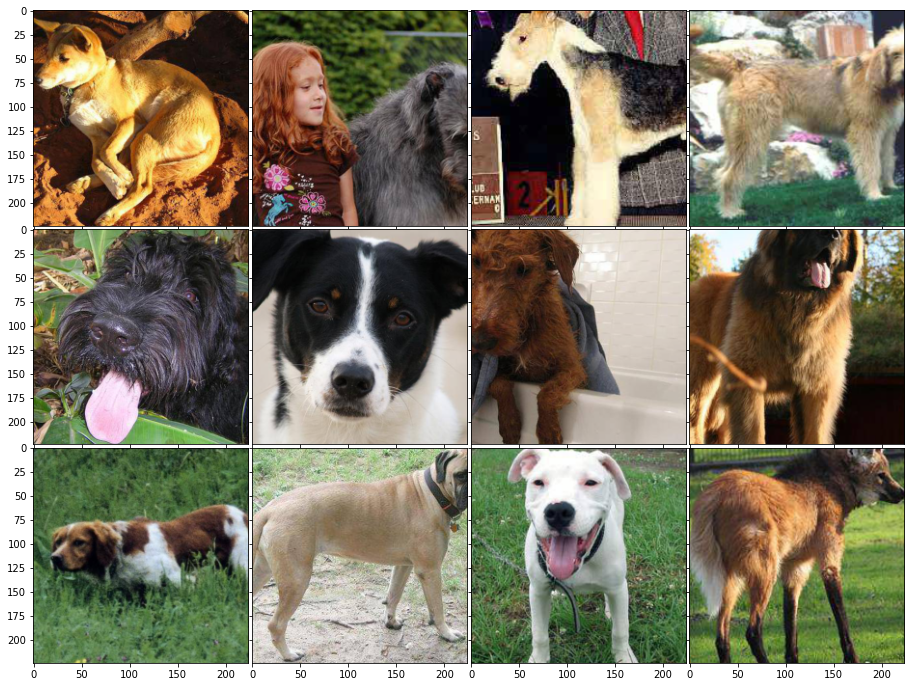

In [13]:
img, label = next(iter(dataloaders['test']))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

We used three convolutional layers with relu activations which are followed by maxpool layers. Also, used two fully connected layers. Between fully connected layers, dropout technique with probability = 0.25 is used to avoid the overfitting.

Define train and test method in general

In [14]:
def train(n_epochs, loaders, model, optimizer, criterion, scheduler, use_cuda, save_path):
    valid_loss_min = np.Inf 
    
    dataset_sizes = {'train': len(loaders['train'].dataset), 
                     'valid': len(loaders['valid'].dataset),
                     'test': len(loaders['test'].dataset)}
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        train_corrects = 0.0
        valid_loss = 0.0
        valid_corrects = 0.0
        
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            output = model(data)
            _, preds = torch.max(output.data, 1)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            # Record the average training loss
            train_loss += loss.data
            train_corrects += torch.sum(preds == target.data)
            
            if batch_idx % 100 == 0:
                print('Epoch: %d \tBatch: %d \tTraining Loss: %.6f' %(epoch, batch_idx + 1, train_loss / ((batch_idx + 1) * 12)))
        
        train_loss = train_loss / dataset_sizes['train']
        train_corrects = train_corrects / dataset_sizes['train']
        
        scheduler.step()

        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            # Update the average validation loss
            output = model(data)
            _, preds = torch.max(output.data, 1)
            loss = criterion(output, target)
            valid_loss += loss.data
            valid_corrects += torch.sum(preds == target.data)
        
        valid_loss = valid_loss / dataset_sizes['valid']
        valid_corrects = valid_corrects / dataset_sizes['valid']
        
        # Print validation statistics 
        print('Epoch: {} \tValidation Loss: {:.4f} \tValidation Acc: {:.4f}'.format(
            epoch, 
            valid_loss,
            valid_corrects
            ))
        
        # Save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model...'.format(valid_loss_min,valid_loss))
            valid_loss_min = valid_loss    

    return model

In [15]:
def test(loaders, model, optimizer, criterion, use_cuda):
    test_loss = 0.0
    test_corrects = 0.0
    
    dataset_sizes = {'train': len(loaders['train'].dataset), 
                     'valid': len(loaders['valid'].dataset),
                     'test': len(loaders['test'].dataset)}
    
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # Update the average validation loss
        output = model(data)
        _, preds = torch.max(output.data, 1)
        loss = criterion(output, target)
        test_loss += loss.data
        test_corrects += torch.sum(preds == target.data)
    
    test_loss = test_loss / dataset_sizes['test']
    test_corrects = test_corrects / dataset_sizes['test']
    
    print('Test Loss: {:.4f} \tTest Acc: {:.4f}'.format(
        test_loss,
        test_corrects
        ))
    
    return test_loss, test_corrects

# ResNet50

ResNet50 is a variant of ResNet model which has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer. It has 3.8 x 10^9 Floating points operations. It is a widely used ResNet model and we have explored ResNet50 architecture in depth. You can load a pretrained version of the network trained on more than a million images from the ImageNet database.

In [16]:
model_resnet = models.resnet50(pretrained=True)

# Freeze training for all "features" layers
for param in model_resnet.parameters():
    param.requires_grad = False
    
# Replace the last fully connected layer with a Linnear layer 120 output
in_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(in_features, 120)

if use_cuda:
    model_resnet = model_resnet.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Setup criterion, optimizer, and learning rate scheduler

In [17]:
criterion = nn.CrossEntropyLoss()
model_resnet_grad_paramaters = filter(lambda p: p.requires_grad, model_resnet.parameters())
optimizer = torch.optim.SGD(model_resnet_grad_paramaters, lr=0.001, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Train the ResNet50 model

In [18]:
n_epoch = 10

model_resnet = train(n_epoch, dataloaders, model_resnet, optimizer, criterion, exp_lr_scheduler, use_cuda, 'model_resnet.pt')

Epoch: 1 	Batch: 1 	Training Loss: 0.410264
Epoch: 1 	Batch: 101 	Training Loss: 0.396061
Epoch: 1 	Batch: 201 	Training Loss: 0.384231
Epoch: 1 	Batch: 301 	Training Loss: 0.372151
Epoch: 1 	Batch: 401 	Training Loss: 0.361058
Epoch: 1 	Batch: 501 	Training Loss: 0.350480
Epoch: 1 	Batch: 601 	Training Loss: 0.340522
Epoch: 1 	Validation Loss: 0.2103 	Validation Acc: 0.5554
Validation loss decreased (inf --> 0.2103).  Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 0.302553
Epoch: 2 	Batch: 101 	Training Loss: 0.266191
Epoch: 2 	Batch: 201 	Training Loss: 0.261574
Epoch: 2 	Batch: 301 	Training Loss: 0.255267
Epoch: 2 	Batch: 401 	Training Loss: 0.250907
Epoch: 2 	Batch: 501 	Training Loss: 0.246000
Epoch: 2 	Batch: 601 	Training Loss: 0.241825
Epoch: 2 	Validation Loss: 0.1206 	Validation Acc: 0.7158
Validation loss decreased (0.2103 --> 0.1206).  Saving model...
Epoch: 3 	Batch: 1 	Training Loss: 0.216707
Epoch: 3 	Batch: 101 	Training Loss: 0.207256
Epoch: 3 	Batch: 201 	Trainin

Test the ResNet50 model

In [19]:
model_resnet.load_state_dict(torch.load('model_resnet.pt'))

resnet_score = test(dataloaders, model_resnet, optimizer, criterion, use_cuda)

Test Loss: 0.0519 	Test Acc: 0.8268


In [20]:
summary(model_resnet, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Train the ResNet50 without freezing the trained layer to see the comparison

In [21]:
model_resnet = models.resnet50(pretrained=True)
    
# Replace the last fully connected layer with a Linnear layer 120 output
in_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(in_features, 120)

if use_cuda:
    model_resnet = model_resnet.cuda()
      
criterion = nn.CrossEntropyLoss()
model_resnet_grad_paramaters = filter(lambda p: p.requires_grad, model_resnet.parameters())
optimizer = torch.optim.SGD(model_resnet_grad_paramaters, lr=0.001, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [22]:
n_epoch = 10

model_resnet = train(n_epoch, dataloaders, model_resnet, optimizer, criterion, exp_lr_scheduler, use_cuda, 'model_resnet.pt')

Epoch: 1 	Batch: 1 	Training Loss: 0.397495
Epoch: 1 	Batch: 101 	Training Loss: 0.391337
Epoch: 1 	Batch: 201 	Training Loss: 0.365259
Epoch: 1 	Batch: 301 	Training Loss: 0.337559
Epoch: 1 	Batch: 401 	Training Loss: 0.314361
Epoch: 1 	Batch: 501 	Training Loss: 0.295547
Epoch: 1 	Batch: 601 	Training Loss: 0.280364
Epoch: 1 	Validation Loss: 0.0925 	Validation Acc: 0.6930
Validation loss decreased (inf --> 0.0925).  Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 0.212460
Epoch: 2 	Batch: 101 	Training Loss: 0.174407
Epoch: 2 	Batch: 201 	Training Loss: 0.173084
Epoch: 2 	Batch: 301 	Training Loss: 0.169585
Epoch: 2 	Batch: 401 	Training Loss: 0.165176
Epoch: 2 	Batch: 501 	Training Loss: 0.165829
Epoch: 2 	Batch: 601 	Training Loss: 0.164917
Epoch: 2 	Validation Loss: 0.0720 	Validation Acc: 0.7386
Validation loss decreased (0.0925 --> 0.0720).  Saving model...
Epoch: 3 	Batch: 1 	Training Loss: 0.214946
Epoch: 3 	Batch: 101 	Training Loss: 0.142928
Epoch: 3 	Batch: 201 	Trainin

In [23]:
model_resnet.load_state_dict(torch.load('model_resnet.pt'))

resnet_score_unfreeze = test(dataloaders, model_resnet, optimizer, criterion, use_cuda)

Test Loss: 0.0511 	Test Acc: 0.8053


# EfficientNet

EfficientNet is a convolutional neural network architecture and scaling method that uniformly scales all dimensions of depth/width/resolution using a compound coefficient. Unlike conventional practice that arbitrary scales these factors, the EfficientNet scaling method uniformly scales network width, depth, and resolution with a set of fixed scaling coefficients.

In [24]:
model_fnet = EfficientNet.from_name('efficientnet-b1')

# Freeze training for all "features" layers
for param in model_fnet.parameters():
    param.requires_grad = True

# Replace the last fully connected layer with a Linnear layer 120 output
in_features = model_fnet._fc.in_features
model_fnet._fc = nn.Linear(in_features, 120)

# Setup criterion, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fnet.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if use_cuda:
    model_fnet = model_fnet.cuda()

Train the EfficientNet model

In [25]:
n_epoch = 10

model_fnet = train(n_epoch, dataloaders, model_resnet, optimizer, criterion, exp_lr_scheduler, use_cuda, 'model_fnet.pt')

Epoch: 1 	Batch: 1 	Training Loss: 0.046499
Epoch: 1 	Batch: 101 	Training Loss: 0.091264
Epoch: 1 	Batch: 201 	Training Loss: 0.090385
Epoch: 1 	Batch: 301 	Training Loss: 0.089355
Epoch: 1 	Batch: 401 	Training Loss: 0.089369
Epoch: 1 	Batch: 501 	Training Loss: 0.089115
Epoch: 1 	Batch: 601 	Training Loss: 0.088980
Epoch: 1 	Validation Loss: 0.0500 	Validation Acc: 0.8194
Validation loss decreased (inf --> 0.0500).  Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 0.118249
Epoch: 2 	Batch: 101 	Training Loss: 0.089264
Epoch: 2 	Batch: 201 	Training Loss: 0.086230
Epoch: 2 	Batch: 301 	Training Loss: 0.087193
Epoch: 2 	Batch: 401 	Training Loss: 0.086816
Epoch: 2 	Batch: 501 	Training Loss: 0.086411
Epoch: 2 	Batch: 601 	Training Loss: 0.086081
Epoch: 2 	Validation Loss: 0.0488 	Validation Acc: 0.8272
Validation loss decreased (0.0500 --> 0.0488).  Saving model...
Epoch: 3 	Batch: 1 	Training Loss: 0.057518
Epoch: 3 	Batch: 101 	Training Loss: 0.084721
Epoch: 3 	Batch: 201 	Trainin

Test the EfficientNet model

In [26]:
model_fnet.load_state_dict(torch.load('model_fnet.pt'))

fnet_score = test(dataloaders, model_fnet, optimizer, criterion, use_cuda)

Test Loss: 0.0499 	Test Acc: 0.8112


In [27]:
summary(model_fnet, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Train the EfficientNet without freezing the trained layer to see the comparison

In [28]:
model_fnet = EfficientNet.from_name('efficientnet-b1')

# Replace the last fully connected layer with a Linnear layer 120 output
in_features = model_fnet._fc.in_features
model_fnet._fc = nn.Linear(in_features, 120)

# Setup criterion, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fnet.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if use_cuda:
    model_fnet = model_fnet.cuda()

In [29]:
n_epoch = 10

model_fnet = train(n_epoch, dataloaders, model_resnet, optimizer, criterion, exp_lr_scheduler, use_cuda, 'model_fnet.pt')

Epoch: 1 	Batch: 1 	Training Loss: 0.112806
Epoch: 1 	Batch: 101 	Training Loss: 0.081649
Epoch: 1 	Batch: 201 	Training Loss: 0.083686
Epoch: 1 	Batch: 301 	Training Loss: 0.085716
Epoch: 1 	Batch: 401 	Training Loss: 0.086136
Epoch: 1 	Batch: 501 	Training Loss: 0.086341
Epoch: 1 	Batch: 601 	Training Loss: 0.086996
Epoch: 1 	Validation Loss: 0.0501 	Validation Acc: 0.8246
Validation loss decreased (inf --> 0.0501).  Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 0.097556
Epoch: 2 	Batch: 101 	Training Loss: 0.085642
Epoch: 2 	Batch: 201 	Training Loss: 0.086573
Epoch: 2 	Batch: 301 	Training Loss: 0.086492
Epoch: 2 	Batch: 401 	Training Loss: 0.085472
Epoch: 2 	Batch: 501 	Training Loss: 0.085881
Epoch: 2 	Batch: 601 	Training Loss: 0.086528
Epoch: 2 	Validation Loss: 0.0500 	Validation Acc: 0.8214
Validation loss decreased (0.0501 --> 0.0500).  Saving model...
Epoch: 3 	Batch: 1 	Training Loss: 0.087841
Epoch: 3 	Batch: 101 	Training Loss: 0.087985
Epoch: 3 	Batch: 201 	Trainin

In [30]:
model_fnet.load_state_dict(torch.load('model_fnet.pt'))

fnet_score_unfreeze = test(dataloaders, model_fnet, optimizer, criterion, use_cuda)

Test Loss: 0.0498 	Test Acc: 0.8102


# VGG16

VGG16 is a convolution neural net architecture that is considered to be one of the excellent vision model architecture till date. Most unique thing about VGG16 is that instead of having a large number of hyper-parameter they focused on having convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture. In the end it has 2 FC(fully connected layers) followed by a softmax for output. The 16 in VGG16 refers to it has 16 layers that have weights. This network is a pretty large network and it has about 138 million (approx) parameters.

In [31]:
model_vgg = models.vgg16_bn(pretrained=True)

# Freeze training for all "features" layers
for param in model_vgg.features.parameters():
    param.require_grad = False
    
in_features = model_vgg.classifier[6].in_features
features = list(model_vgg.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(in_features, 120)]) # Add our layer with 120 outputs
model_vgg.classifier = nn.Sequential(*features)

# Setup criterion, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if use_cuda:
    model_vgg = model_vgg.cuda()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Train the VGG16 model

In [32]:
n_epoch = 10

model_vgg = train(n_epoch, dataloaders, model_vgg, optimizer, criterion, exp_lr_scheduler, use_cuda, 'model_vgg.pt')

Epoch: 1 	Batch: 1 	Training Loss: 0.422318
Epoch: 1 	Batch: 101 	Training Loss: 0.371789
Epoch: 1 	Batch: 201 	Training Loss: 0.320839
Epoch: 1 	Batch: 301 	Training Loss: 0.288995
Epoch: 1 	Batch: 401 	Training Loss: 0.266031
Epoch: 1 	Batch: 501 	Training Loss: 0.250430
Epoch: 1 	Batch: 601 	Training Loss: 0.239939
Epoch: 1 	Validation Loss: 0.0767 	Validation Acc: 0.7112
Validation loss decreased (inf --> 0.0767).  Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 0.131197
Epoch: 2 	Batch: 101 	Training Loss: 0.167109
Epoch: 2 	Batch: 201 	Training Loss: 0.164593
Epoch: 2 	Batch: 301 	Training Loss: 0.165646
Epoch: 2 	Batch: 401 	Training Loss: 0.165499
Epoch: 2 	Batch: 501 	Training Loss: 0.165647
Epoch: 2 	Batch: 601 	Training Loss: 0.164749
Epoch: 2 	Validation Loss: 0.0858 	Validation Acc: 0.6897
Epoch: 3 	Batch: 1 	Training Loss: 0.157470
Epoch: 3 	Batch: 101 	Training Loss: 0.145673
Epoch: 3 	Batch: 201 	Training Loss: 0.148442
Epoch: 3 	Batch: 301 	Training Loss: 0.149890
E

Test the VGG16 model

In [33]:
model_vgg.load_state_dict(torch.load('model_vgg.pt'))

vgg_score = test(dataloaders, model_vgg, optimizer, criterion, use_cuda)

Test Loss: 0.0522 	Test Acc: 0.8190


In [34]:
summary(model_vgg, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

Train the VGG16 without freezing the trained layer to see the comparison

In [35]:
model_vgg = models.vgg16_bn(pretrained=True)
    
in_features = model_vgg.classifier[6].in_features
features = list(model_vgg.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(in_features, 120)]) # Add our layer with 120 outputs
model_vgg.classifier = nn.Sequential(*features)

# Setup criterion, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if use_cuda:
    model_vgg = model_vgg.cuda()

In [36]:
n_epoch = 10

model_vgg = train(n_epoch, dataloaders, model_vgg, optimizer, criterion, exp_lr_scheduler, use_cuda, 'model_vgg.pt')

Epoch: 1 	Batch: 1 	Training Loss: 0.412152
Epoch: 1 	Batch: 101 	Training Loss: 0.372527
Epoch: 1 	Batch: 201 	Training Loss: 0.321909
Epoch: 1 	Batch: 301 	Training Loss: 0.288038
Epoch: 1 	Batch: 401 	Training Loss: 0.265293
Epoch: 1 	Batch: 501 	Training Loss: 0.250003
Epoch: 1 	Batch: 601 	Training Loss: 0.237918
Epoch: 1 	Validation Loss: 0.0866 	Validation Acc: 0.6851
Validation loss decreased (inf --> 0.0866).  Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 0.172186
Epoch: 2 	Batch: 101 	Training Loss: 0.168360
Epoch: 2 	Batch: 201 	Training Loss: 0.165623
Epoch: 2 	Batch: 301 	Training Loss: 0.166401
Epoch: 2 	Batch: 401 	Training Loss: 0.165877
Epoch: 2 	Batch: 501 	Training Loss: 0.164615
Epoch: 2 	Batch: 601 	Training Loss: 0.164349
Epoch: 2 	Validation Loss: 0.0796 	Validation Acc: 0.7073
Validation loss decreased (0.0866 --> 0.0796).  Saving model...
Epoch: 3 	Batch: 1 	Training Loss: 0.139937
Epoch: 3 	Batch: 101 	Training Loss: 0.145488
Epoch: 3 	Batch: 201 	Trainin

In [37]:
model_vgg.load_state_dict(torch.load('model_vgg.pt'))

vgg_score_unfreeze = test(dataloaders, model_vgg, optimizer, criterion, use_cuda)

Test Loss: 0.0536 	Test Acc: 0.7975


# InceptionV3

Inception-v3 is a convolutional neural network architecture from the Inception family that makes several improvements including using Label Smoothing, Factorized 7 x 7 convolutions, and the use of an auxiliary classifer to propagate label information lower down the network (along with the use of batch normalization for layers in the sidehead).

For inceptionV3, we need to modify the train, test, and image transformation

For the train, and test, we modify that the loss receive ouput.logits as the inception3 outputs has more than logits

For the image transformation, we resize it into 299x299 for inceptionV3 able to read the input, thus below will re read the input

In [38]:
def inception_train(n_epochs, loaders, model, optimizer, criterion, scheduler, use_cuda, save_path):
    valid_loss_min = np.Inf 
    
    dataset_sizes = {'train': len(loaders['train'].dataset), 
                     'valid': len(loaders['valid'].dataset),
                     'test': len(loaders['test'].dataset)}
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        train_corrects = 0.0
        valid_loss = 0.0
        valid_corrects = 0.0
        
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            output = model(data)
            _, preds = torch.max(output.logits.data, 1)
            loss = criterion(output.logits, target)
            loss.backward()
            optimizer.step()
            # Record the average training loss
            train_loss += loss.data
            train_corrects += torch.sum(preds == target.data)
            
            if batch_idx % 100 == 0:
                print('Epoch: %d \tBatch: %d \tTraining Loss: %.6f' %(epoch, batch_idx + 1, train_loss / ((batch_idx + 1) * 12)))
        
        train_loss = train_loss / dataset_sizes['train']
        train_corrects = train_corrects / dataset_sizes['train']
        
        scheduler.step()

        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            # Update the average validation loss
            output = model(data)
            _, preds = torch.max(output.data, 1)
            loss = criterion(output, target)
            valid_loss += loss.data
            valid_corrects += torch.sum(preds == target.data)
        
        valid_loss = valid_loss / dataset_sizes['valid']
        valid_corrects = valid_corrects / dataset_sizes['valid']
        
        # Print validation statistics 
        print('Epoch: {} \tValidation Loss: {:.4f} \tValidation Acc: {:.4f}'.format(
            epoch, 
            valid_loss,
            valid_corrects
            ))
        
        # Save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model...'.format(valid_loss_min,valid_loss))
            valid_loss_min = valid_loss    

    return model

In [39]:
def inception_test(loaders, model, optimizer, criterion, use_cuda):
    test_loss = 0.0
    test_corrects = 0.0
    
    dataset_sizes = {'train': len(loaders['train'].dataset), 
                     'valid': len(loaders['valid'].dataset),
                     'test': len(loaders['test'].dataset)}
    
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # Update the average validation loss
        output = model(data)
        _, preds = torch.max(output.data, 1)
        loss = criterion(output, target)
        test_loss += loss.data
        test_corrects += torch.sum(preds == target.data)
    
    test_loss = test_loss / dataset_sizes['test']
    test_corrects = test_corrects / dataset_sizes['test']
    
    print('Test Loss: {:.4f} \tTest Acc: {:.4f}'.format(
        test_loss,
        test_corrects
        ))
    
    return test_loss, test_corrects

In [40]:
PATH = '../input/dog-breed-identification/'
labels = pd.read_csv(PATH + 'labels.csv')
labelnames = pd.read_csv(PATH + 'sample_submission.csv').keys()[1:]

In [41]:
codes = range(len(labelnames))
breed_to_code = dict(zip(labelnames, codes))
code_to_breed = dict(zip(codes, labelnames))
labels['target'] =  [breed_to_code[x] for x in labels.breed]
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.75)
temp = labels_pivot[~labels_pivot['id'].isin(train['id'])]
valid = temp.sample(frac=0.6)
test = temp[~temp['id'].isin(valid['id'])]

In [42]:
# Image transformations
img_transform = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(size = 299),
        transforms.RandomRotation(degrees = 30),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=299),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  
    ]),
    'valid':transforms.Compose([
        transforms.Resize(size = 299),
        transforms.CenterCrop(size = 299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test':transforms.Compose([
        transforms.Resize(size = 299),
        transforms.CenterCrop(size = 299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [43]:
class DogBreedDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, img_dir, label, transform):
        'Initialization'
        self.img_dir = img_dir
        self.transform = transform
        self.label = label

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.label)

    def __getitem__(self, index):
        if self.label is not None:
            img_name = '{}.jpg'.format(self.label.iloc[index, 0])
            fullname = self.img_dir + img_name
            image = Image.open(fullname)
            label = self.label.iloc[index, 1:].astype('float').to_numpy()
            label = np.argmax(label)
            if self.transform:
                image = self.transform(image)
            return [image, label]

In [44]:
batch_size = 12
num_workers = 4
train_img = DogBreedDataset(PATH+'train/', train, transform = img_transform['train'])
valid_img = DogBreedDataset(PATH+'train/', valid, transform = img_transform['valid'])
test_img = DogBreedDataset(PATH+'train/', test, transform = img_transform['test'])


dataloaders={
    'train':torch.utils.data.DataLoader(train_img, batch_size, num_workers = num_workers, shuffle=True),
    'valid':torch.utils.data.DataLoader(valid_img, batch_size, num_workers = num_workers, shuffle=False),
    'test':torch.utils.data.DataLoader(test_img, batch_size, num_workers = num_workers, shuffle=False)
}


In [45]:
model_inception = models.inception_v3(pretrained=True)

# Freeze training for all "features" layers
for param in model_inception.parameters():
    param.requires_grad = False

# Setup the last layer net to handle 120 outputs
# Handle the auxilary net
aux_in_features = model_inception.AuxLogits.fc.in_features
model_inception.AuxLogits.fc = nn.Linear(aux_in_features, 120)
# Handle the primary net
in_features = model_inception.fc.in_features
model_inception.fc = nn.Linear(in_features, 120)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_inception.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if use_cuda:
    model_inception = model_inception.cuda()

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Train the InceptionV3 model

In [46]:
n_epoch = 10

model_inception = inception_train(n_epoch, dataloaders, model_inception, optimizer, criterion, exp_lr_scheduler, use_cuda, 'model_inception.pt')

Epoch: 1 	Batch: 1 	Training Loss: 0.418129
Epoch: 1 	Batch: 101 	Training Loss: 0.397249
Epoch: 1 	Batch: 201 	Training Loss: 0.391342
Epoch: 1 	Batch: 301 	Training Loss: 0.384764
Epoch: 1 	Batch: 401 	Training Loss: 0.378594
Epoch: 1 	Batch: 501 	Training Loss: 0.372411
Epoch: 1 	Batch: 601 	Training Loss: 0.366707
Epoch: 1 	Validation Loss: 0.2849 	Validation Acc: 0.5626
Validation loss decreased (inf --> 0.2849).  Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 0.306385
Epoch: 2 	Batch: 101 	Training Loss: 0.318836
Epoch: 2 	Batch: 201 	Training Loss: 0.312069
Epoch: 2 	Batch: 301 	Training Loss: 0.308121
Epoch: 2 	Batch: 401 	Training Loss: 0.303592
Epoch: 2 	Batch: 501 	Training Loss: 0.298408
Epoch: 2 	Batch: 601 	Training Loss: 0.293650
Epoch: 2 	Validation Loss: 0.1973 	Validation Acc: 0.7119
Validation loss decreased (0.2849 --> 0.1973).  Saving model...
Epoch: 3 	Batch: 1 	Training Loss: 0.241488
Epoch: 3 	Batch: 101 	Training Loss: 0.258143
Epoch: 3 	Batch: 201 	Trainin

Test the InceptionV3 model

In [47]:
model_inception.load_state_dict(torch.load('model_inception.pt'))

inception_score = inception_test(dataloaders, model_inception, optimizer, criterion, use_cuda)

Test Loss: 0.0605 	Test Acc: 0.8474


In [48]:
summary(model_inception, input_size=(3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

Train the InceptionV3 without freezing the trained layer to see the comparison

In [49]:
model_inception = models.inception_v3(pretrained=True)

# Setup the last layer net to handle 120 outputs
# Handle the auxilary net
aux_in_features = model_inception.AuxLogits.fc.in_features
model_inception.AuxLogits.fc = nn.Linear(aux_in_features, 120)
# Handle the primary net
in_features = model_inception.fc.in_features
model_inception.fc = nn.Linear(in_features, 120)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_inception.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if use_cuda:
    model_inception = model_inception.cuda()

In [50]:
n_epoch = 10

model_inception = inception_train(n_epoch, dataloaders, model_inception, optimizer, criterion, exp_lr_scheduler, use_cuda, 'model_inception.pt')

Epoch: 1 	Batch: 1 	Training Loss: 0.423003
Epoch: 1 	Batch: 101 	Training Loss: 0.396248
Epoch: 1 	Batch: 201 	Training Loss: 0.381990
Epoch: 1 	Batch: 301 	Training Loss: 0.364001
Epoch: 1 	Batch: 401 	Training Loss: 0.344547
Epoch: 1 	Batch: 501 	Training Loss: 0.326532
Epoch: 1 	Batch: 601 	Training Loss: 0.310056
Epoch: 1 	Validation Loss: 0.1054 	Validation Acc: 0.6962
Validation loss decreased (inf --> 0.1054).  Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 0.209018
Epoch: 2 	Batch: 101 	Training Loss: 0.195078
Epoch: 2 	Batch: 201 	Training Loss: 0.191785
Epoch: 2 	Batch: 301 	Training Loss: 0.184947
Epoch: 2 	Batch: 401 	Training Loss: 0.181002
Epoch: 2 	Batch: 501 	Training Loss: 0.176525
Epoch: 2 	Batch: 601 	Training Loss: 0.173117
Epoch: 2 	Validation Loss: 0.0643 	Validation Acc: 0.7816
Validation loss decreased (0.1054 --> 0.0643).  Saving model...
Epoch: 3 	Batch: 1 	Training Loss: 0.134771
Epoch: 3 	Batch: 101 	Training Loss: 0.150399
Epoch: 3 	Batch: 201 	Trainin

In [51]:
model_inception.load_state_dict(torch.load('model_inception.pt'))

inception_score_unfreeze = inception_test(dataloaders, model_inception, optimizer, criterion, use_cuda)

Test Loss: 0.0442 	Test Acc: 0.8337


# Summary

In [52]:
# print('CNN from scratch Acc: {:.4f}'.format(scratch_score[1]))
print('ResNet50 Acc: {:.4f}'.format(resnet_score[1]))
print('EfficientNet Acc: {:.4f}'.format(fnet_score[1]))
print('VGG16 Acc: {:.4f}'.format(vgg_score[1]))
print('Inception Acc: {:.4f}'.format(inception_score[1]))

# print('CNN from scratch Loss: {:.4f}'.format(scratch_score[0]))
print('ResNet50 Loss: {:.4f}'.format(resnet_score[0]))
print('EfficientNet Loss: {:.4f}'.format(fnet_score[0]))
print('VGG16 Loss: {:.4f}'.format(vgg_score[0]))
print('Inception Loss: {:.4f}'.format(inception_score[0]))

ResNet50 Acc: 0.8268
EfficientNet Acc: 0.8112
VGG16 Acc: 0.8190
Inception Acc: 0.8474
ResNet50 Loss: 0.0519
EfficientNet Loss: 0.0499
VGG16 Loss: 0.0522
Inception Loss: 0.0605


In [53]:
model_df = pd.DataFrame(data=[["ResNet50", float(format(resnet_score[1]))]], 
                          columns=['Model', 'Accuracy'])

temp_df = pd.DataFrame(data=[["ResNet50 Unfreeze", float(format(resnet_score_unfreeze[1]))]], 
                          columns=['Model', 'Accuracy'])
model_df = model_df.append(temp_df, ignore_index=True)

temp_df = pd.DataFrame(data=[["EfficientNet", float(format(fnet_score[1]))]], 
                          columns=['Model', 'Accuracy'])
model_df = model_df.append(temp_df, ignore_index=True)

temp_df = pd.DataFrame(data=[["EfficientNet Unfreeze", float(format(fnet_score_unfreeze[1]))]], 
                          columns=['Model', 'Accuracy'])
model_df = model_df.append(temp_df, ignore_index=True)

temp_df = pd.DataFrame(data=[["VGG16", float(format(vgg_score[1]))]], 
                          columns=['Model', 'Accuracy'])
model_df = model_df.append(temp_df, ignore_index=True)

temp_df = pd.DataFrame(data=[["VGG16 Unfreeze", float(format(vgg_score_unfreeze[1]))]], 
                          columns=['Model', 'Accuracy'])
model_df = model_df.append(temp_df, ignore_index=True)

temp_df = pd.DataFrame(data=[["InceptionV3", float(format(inception_score[1]))]], 
                          columns=['Model', 'Accuracy'])
model_df = model_df.append(temp_df, ignore_index=True)

temp_df = pd.DataFrame(data=[["InceptionV3 Unfreeze", float(format(inception_score_unfreeze[1]))]], 
                          columns=['Model', 'Accuracy'])
model_df = model_df.append(temp_df, ignore_index=True)

model_df

,Model,Accuracy
0,ResNet50,0.826810
1,ResNet50 Unfreeze,0.805284
2,EfficientNet,0.811155
3,EfficientNet Unfreeze,0.810176
4,VGG16,0.818982
5,VGG16 Unfreeze,0.797456
6,InceptionV3,0.847358
7,InceptionV3 Unfreeze,0.833659


<AxesSubplot:ylabel='Model'>

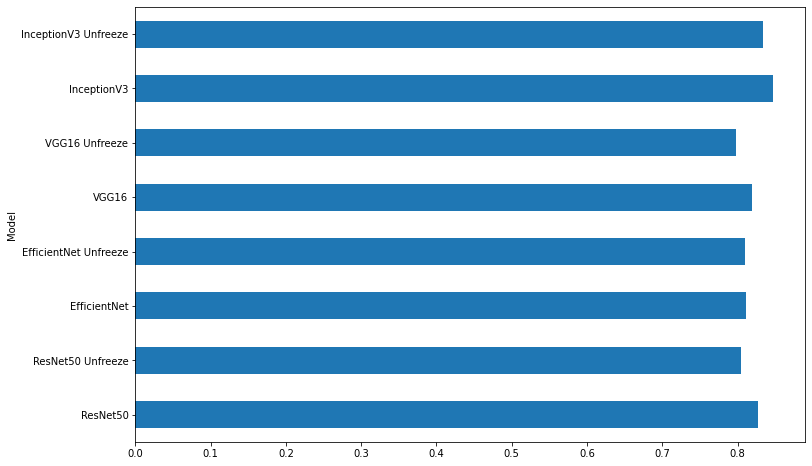

In [54]:
model_df.set_index('Model', inplace=True)
model_df['Accuracy'].plot(kind='barh', figsize=(12, 8))

The InceptionV3 model successfully become the top 1 which predict 120 breeds with 85.4% accuracy. 

Followed by EfficientNet with 85.7% accuracy, Resnet with 82.7% accuracy, and VGG16 with 80.0% accuracy.

And the unfreeze version is slightly weaker than the freeze trained layer, possibly of overfitting as can be seen that in the first 3 epoch, the unfreeze is better but after some high amount of epoch, it's weaker ~1 to 2 percent